In [1]:
import importlib
import data_helpers

# make the training data dirs
data_helpers.make_data_split()

data/1/*.jpg data/0/*.jpg
copied c1: 100, c0: 101


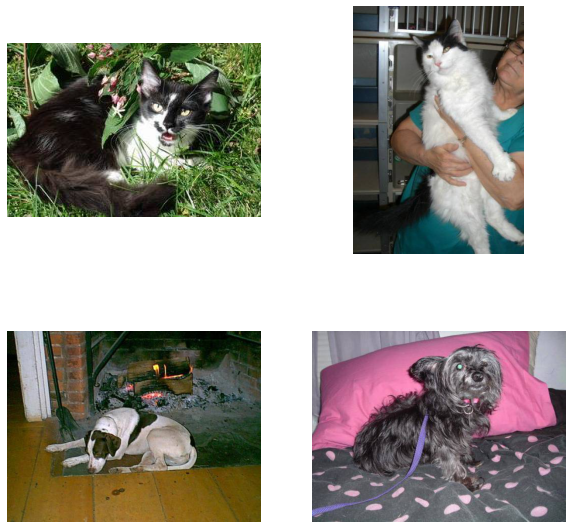

In [2]:
data_helpers.sample_raw_images()

In [3]:
trainloader, testloader = data_helpers.dataloaders()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
1
0
0


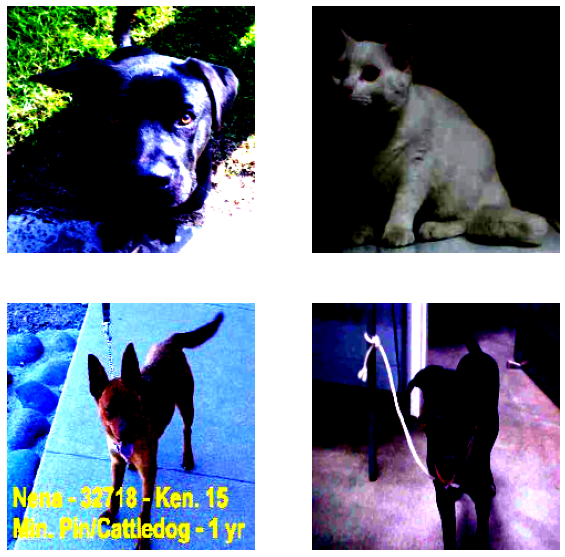

In [4]:
data_helpers.vis_loader(trainloader)

In [5]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
import training_funcs
import torch

importlib.reload(training_funcs)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = training_funcs.make_model(device)

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = training_funcs.make_train_step(model, optimizer, loss_fn)

/Users/akutvone/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/akutvone/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#from tqdm import tqdm

losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in enumerate(trainloader): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
    if i % 10 == 0:
        print(loss.tolist(), i, len(trainloader))
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))


  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    confusion_matrix = torch.zeros(2, 2)
    
    for x_batch, y_batch in testloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(testloader)
      val_losses.append(val_loss.item())   
    
      # model outputs linears
      preds = torch.round(torch.sigmoid(yhat))
    
      #print(preds)
      #print(y_batch)
    
      for t, p in zip(y_batch.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    

    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

0.012040773406624794 0 41
0.021311858668923378 10 41
0.07703783363103867 20 41
0.06315001100301743 30 41
0.6273723244667053 40 41

Epoch : 1, train loss : 0.13332733511924744
tensor([[19.,  1.],
        [ 0., 20.]])
tensor([0.9500, 1.0000])
Epoch : 1, val loss : 0.6273723244667053
0.05434061959385872 0 41
0.20116311311721802 10 41
0.022794216871261597 20 41
0.04565224051475525 30 41
0.34238120913505554 40 41

Epoch : 2, train loss : 0.277545303106308
tensor([[17.,  3.],
        [ 0., 20.]])
tensor([0.8500, 1.0000])
Epoch : 2, val loss : 0.3423812687397003
0.021472018212080002 0 41
0.024494964629411697 10 41
0.019947635009884834 20 41
0.278544545173645 30 41


KeyboardInterrupt: 